In [1]:
import pandas as pd
import numpy as np

In [2]:
#!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv

### Preparing the dataset

In [3]:
df = pd.read_csv('laptops.csv')

In [4]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [5]:
df.columns

Index(['laptop', 'status', 'brand', 'model', 'cpu', 'ram', 'storage',
       'storage_type', 'gpu', 'screen', 'touch', 'final_price'],
      dtype='object')

In [6]:
# df.dtypes

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### EDA
### Look at the final_price variable. Does it have a long tail?

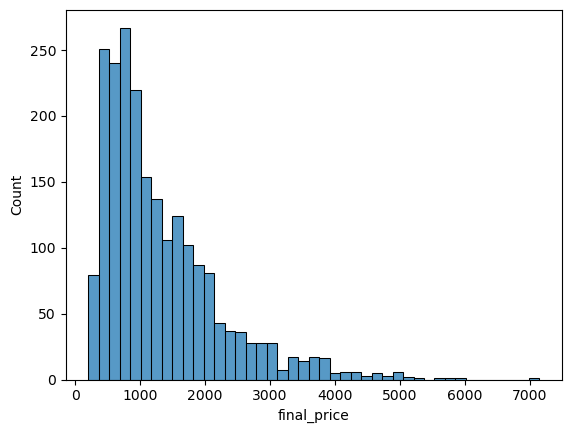

In [8]:
sns.histplot(df.final_price)
plt.show()

In [9]:
# sns.histplot(df.final_price[df.final_price < 5000], bins=50)
# plt.show()

In [10]:
price_logs = np.log1p(df.final_price)

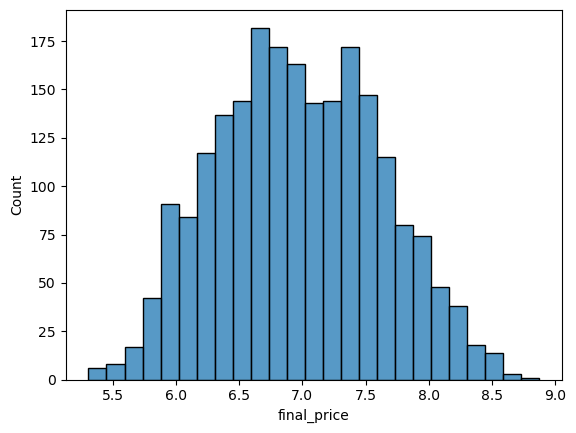

In [11]:
sns.histplot(price_logs)
plt.show()

### Question 1
#### What's the median (50% percentile) for variable 'ram'?


In [12]:
missing_columns = df.isnull().sum()
columns_with_missing_values = missing_columns[missing_columns > 0]
columns_with_missing_values

storage_type      42
gpu             1371
screen             4
dtype: int64

In [13]:
# for col in df.columns:
    # print(col)
    # print(df[col].unique()[:5])
    # print(df[col].nunique())
    # print()

### Question 2
#### What's the median (50% percentile) for variable 'ram'?

In [14]:
screen_m = df["screen"].median()
screen_m

15.6

### Prepare and split the dataset

In [15]:
n = len(df)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test
n

2160

In [16]:
n_train,n_val,n_test

(1296, 432, 432)

In [17]:
def prepare_dataset(n,seed):
    idx = np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(idx)
    df_train = df.iloc[idx[:n_train]].copy()
    df_val = df.iloc[idx[n_train:n_train+n_val]].copy()
    df_test = df.iloc[idx[n_train+n_val:]].copy()
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    # y_train = np.log1p(df_train.final_price.values)
    # y_val = np.log1p(df_val.final_price.values)
    # y_test = np.log1p(df_test.final_price.values)
    y_train = (df_train.final_price.values)
    y_val = (df_val.final_price.values)
    y_test = (df_test.final_price.values)
    return df_train, df_val, df_test, y_train, y_val, y_test

In [18]:
df_train, df_val, df_test, y_train, y_val, y_test = prepare_dataset(n,42)

In [19]:
len(df_train), len(df_val), len(df_test),len(y_train), len(y_val), len(y_test)

(1296, 432, 432, 1296, 432, 432)

In [20]:
# del df_train['final_price']
# del df_val['final_price']
# del df_test['final_price']

### Q3

In [21]:
base = ['ram', 'screen', 'storage']

In [22]:
def prepare_X(df,fillval = 0):
    df_num = df[base]
    df_num = df_num.fillna(fillval)
    X = df_num.values
    return X

In [23]:
def train_linear_regression(X, y, r=0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [24]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [25]:
X_train = prepare_X(df_train)

In [26]:
w0, w = train_linear_regression(X_train, y_train)
X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)
val = rmse(y_val, y_pred)
round(val, 2)

597.36

In [27]:
X_train = prepare_X(df_train,screen_m)
w0, w = train_linear_regression(X_train, y_train)
X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)
val = rmse(y_val, y_pred)
round(val, 2)

597.73

### Q4

In [28]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [29]:
rlist = [0, 0.01, 0.1, 1, 5, 10, 100]

In [30]:
#X_train = prepare_X(df_train)
for i in range(len(rlist)):
    X_train = prepare_X(df_train)
    w0, w = train_linear_regression_reg(X_train, y_train, r=rlist[i])
    X_val = prepare_X(df_val)
    y_pred = w0 + X_val.dot(w)
    val = rmse(y_val, y_pred)
    print('{}\t>>> {},'.format(rlist[i], round(val,2)))


0	>>> 597.36,
0.01	>>> 597.36,
0.1	>>> 597.35,
1	>>> 597.21,
5	>>> 597.01,
10	>>> 597.06,
100	>>> 597.9,


### Q5

In [31]:
def showImages(y_val,y_pred):
    sns.histplot(y_pred, color='red', alpha=0.5, bins=50)
    sns.histplot(y_val, color='blue', alpha=0.5, bins=50)
    plt.show()

In [32]:
seed_vals = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [33]:
scores = []
for i in range(len(seed_vals)):
    df_train, df_val, df_test, y_train, y_val, y_test = prepare_dataset(n,i)
    X_train = prepare_X(df_train)
    w0, w = train_linear_regression(X_train, y_train)
    X_val = prepare_X(df_val)
    y_pred = w0 + X_val.dot(w)
    val = rmse(y_val, y_pred)
    # showImages(y_val,y_pred)
    scores.append(val)

In [34]:
round(np.std(scores),3)

29.176

### Q6

In [35]:
# df_train, df_val, df_test, y_train, y_val, y_test = prepare_dataset(n,9)
df_full_train = pd.concat([df_train, df_val])
df_full_train = df_full_train.reset_index(drop=True)
y_full_train = np.concatenate([y_train, y_val])
X_train = prepare_X(df_full_train)
w0, w = train_linear_regression_reg(X_train, y_full_train)
X_test = prepare_X(df_test)
y_pred = w0 + X_test.dot(w)
val = rmse(y_test, y_pred)
round(val,3)
# showImages(y_test,y_pred)

608.61

In [36]:
# sns.histplot(y_pred, label='prediction', color='red', alpha=0.5, bins=50)
# sns.histplot(y_test, label='target', color='blue',  alpha=0.5, bins=50)
# plt.show()

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [38]:
# rmse_scores = []
# for i in range(len(seed_vals)):
#     df_train, df_val, df_test, y_train, y_val, y_test = prepare_dataset(n,i)
#     X_train = prepare_X(df_train)
#     model = LinearRegression()
#     model.fit(X_train, y_train)
#     X_val = prepare_X(df_val)
#     y_pred_val = model.predict(X_val)
#     mse = mean_squared_error(y_val, y_pred_val)
#     if mse >= 0:
#         rmse_val = np.sqrt(mse)
#         rmse_scores.append(rmse_val)
#     else:
#         print(f"Encountered negative MSE for seed {seed}. Skipping RMSE calculation.")

In [39]:
# rmse_scores

In [40]:
# if rmse_scores:
#     rmse_std = np.std(rmse_scores)
#     rmse_std = round(rmse_std, 3)
#     print(f"RMSE scores for different seeds: {rmse_scores}")
#     print(f"Standard deviation of RMSE scores: {rmse_std}")
# else:
#     print("No valid RMSE scores to calculate the standard deviation.")

In [41]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [42]:
# df_train, df_val, df_test, y_train, y_val, y_test = prepare_dataset(n,9)
# df_full_train = pd.concat([df_train, df_val])
# df_full_train = df_full_train.reset_index(drop=True)
# y_full_train = np.concatenate([y_train, y_val])
# X_train = prepare_X(df_full_train)
# X_test = prepare_X(df_test)
# ridge_model = Ridge(alpha=0.001)  # alpha is the regularization strength in Ridge regression
# ridge_model.fit(X_train, y_full_train)

# # Step 5: Predict on the test dataset and calculate RMSE
# y_pred_test = ridge_model.predict(X_test)
# rmse_test = np.sqrt(mean_squad_error(y_test, y_pred_test))

# # Round the RMSE to 2 decimal places
# rmse_test = round(rmse_test, 2)

# # Output the RMSE on the test dataset
# print(f"RMSE on the test dataset: {rmse_test}")

In [43]:
# for i in range(len(rlist)):
#     df_train, df_val, df_test, y_train, y_val, y_test = prepare_dataset(n,i)
#     X_train = prepare_X(df_train)
#     ridge_model = Ridge(alpha=rlist[i])  # alpha is the regularization strength in Ridge regression
#     ridge_model.fit(X_train, y_train)
#     X_val = prepare_X(df_val)
#     y_pred = ridge_model.predict(X_val)
#     rmse = np.sqrt(mean_squared_error(y_val, y_pred))
#     print('{}\t>>> {},'.format(rlist[i], round(rmse,2)))